# 🕵️ Forensische Datenanalyse von Weblogs mit DuckLake (DuckDB)

Dieses Notebook dokumentiert die forensische Untersuchung von Weblog-Daten zur Identifizierung und zum Beweis einer simulierten **Datenmanipulation**.

**DuckLake** (eine Erweiterung für DuckDB) wird verwendet. DuckLake erstellt für jede Schreiboperation einen unveränderlichen **Snapshot** (Version). Hierfür wird das **Time Travel**-Feature von DuckLake genutzt, um unveränderliche Snapshots früherer Datenzustände zu rekonstruieren und so den Originalzustand mit dem manipulierten Zustand zu vergleichen.


## 1. Vorbereitung und Daten-Setup

### Importe einfügen

In [1]:
!pip install duckdb


In [2]:
import duckdb
import os
import time
from datetime import datetime

Der Code richtet eine persistente DuckDB-Datenbank ein und erstellt separate Verzeichnisse für Metadaten und Daten, um eine saubere Trennung zu gewährleisten. Anschließend wird die DuckLake-Erweiterung installiert, geladen und ein Katalog mit dem definierten Speicherort angebunden. Zum Schluss wird dieser Katalog als Standard gesetzt, sodass alle weiteren SQL-Operationen automatisch darin ausgeführt werden.

In [3]:
# 1. Konfiguriere die Pfade
# Wir verwenden ein Verzeichnis für die Metadaten und ein separates für die Daten (best practice)
DUCKLAKE_METADATA_PATH = 'ducklake_metadata.ducklake'
DUCKLAKE_DATA_PATH = 'ducklake_data_files'
CATALOG_NAME = 'weblog_lake'

# Erstelle die Verzeichnisse, falls sie noch nicht existieren
os.makedirs(DUCKLAKE_DATA_PATH, exist_ok=True)

# 2. Verbinde mit DuckDB
# Die Verbindung zu einer permanenten DB ist für Langlebigkeit der Demo besser
con = duckdb.connect(database='weblog_demo.duckdb')

# 3. Installiere und lade die DuckLake-Erweiterung
con.sql("INSTALL ducklake;")
con.sql("LOAD ducklake;")

# 4. Attache den DuckLake-Katalog
attach_query = f"""
    ATTACH 'ducklake:{DUCKLAKE_METADATA_PATH}' AS {CATALOG_NAME} (DATA_PATH '{DUCKLAKE_DATA_PATH}');
"""
con.sql(attach_query)

# 5. Setze den DuckLake-Katalog als Standard
con.sql(f"USE {CATALOG_NAME};")

print(f"✅ DuckLake '{CATALOG_NAME}' erfolgreich erstellt und verbunden.")


✅ DuckLake 'weblog_lake' erfolgreich erstellt und verbunden.


## Code


### Link zum Datensatz
https://www.kaggle.com/datasets/shawon10/web-log-dataset

Der Datensatz enthält Server-Logdaten des RUET Online Judge (RUET OJ), einem Online-Bewertungssystem einer Universität. Er umfasst 16.008 Einträge mit vier Spalten: IP-Adresse, Zeitstempel, aufgerufene URL und HTTP-Statuscode. Ziel ist es, das Nutzerverhalten und die Serveraktivität zu analysieren, z. B. Login-Vorgänge oder Seitenaufrufe.

In [4]:
! pip install -q kaggle

In [5]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Übergabe von Kaggle Benutzer Daten:
{"username":"....","key":"...."}

In [6]:
# ... Hier Ihre JSON Cred als dictionary eingeben
d_json_cred ={"username":"lizzldizzl","key":"7126d6d48a18986c8a8704fbb94e4a44"}

Kaggle Zugangsdaten speichern



In [7]:
import pandas as pd
kaggle_cred = pd.DataFrame(d_json_cred, index=[0]).to_json("~/.kaggle/kaggle.json")

Authorisierung geben dass Kaggle Daten heruntergeladen werden dürfen

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d shawon10/web-log-dataset

Dataset URL: https://www.kaggle.com/datasets/shawon10/web-log-dataset
License(s): CC0-1.0
web-log-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


Unzip der Daten

In [10]:
!unzip web-log-dataset.zip -d ./data

Archive:  web-log-dataset.zip
replace ./data/weblog.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: ./data/weblog.csv       


## 2. DuckLake-Initialisierung und Snapshot 1 (Basis-Beweis)



Die Rohdaten werden in Pandas geladen, bereinigt und anschließend in den DuckLake-Katalog als erster unveränderlicher Zustand (Snapshot 1) eingefügt. Dies sichert den Original-Beweis.

In [11]:
import duckdb, os
import pandas as pd
import time
from datetime import datetime # Import datetime

# --- Pfade & Namen ---
LOG_PATH = './data/weblog.csv' # Pfad zur Logdatei
DUCKLAKE_METADATA_PATH = 'forensic_evidence.ducklake'
DUCKLAKE_DATA_PATH = 'forensic_data_files'
CATALOG_NAME = 'forensic_log_archive'
TABLE_NAME = 'access_logs'

# Ordner erstellen
os.makedirs(DUCKLAKE_DATA_PATH, exist_ok=True)

# --- Datenbereinigung und Transformation ---
try:
    # 1. Daten einlesen
    df = pd.read_csv(LOG_PATH)

    # 2. Spaltennamen standardisieren
    df.columns = df.columns.str.strip().str.lower()

    # 3. Zeitstempel konvertieren (entfernt '[', nutzt Apache Log Format)
    df['time'] = pd.to_datetime(
        df['time'].astype(str).str.replace("[", "", regex=False),
        format="%d/%b/%Y:%H:%M:%S",
        errors="coerce"
    )

    # 4. Spaltenumbenennung ('staus' -> 'status_code' und 'time' -> 'timestamp')
    df.rename(columns={'time': 'timestamp', 'staus': 'status_code'}, inplace=True)

    # 5. Statuscodes in robusten Integer-Typ konvertieren
    df['status_code'] = pd.to_numeric(
        df['status_code'],
        errors='coerce'
    ).astype(pd.Int64Dtype())

    # 6. Finale Spaltenauswahl für die Archivierung
    df = df[['timestamp', 'ip', 'url', 'status_code']]
    print(f"✅ Rohdaten erfolgreich bereinigt. {len(df)} Einträge bereit zur Archivierung.")

except FileNotFoundError:
    print(f"FEHLER: Datei nicht gefunden unter {LOG_PATH}. Bitte stellen Sie sicher, dass `weblog.csv` im Verzeichnis `./data/` liegt.")
    raise


# --- DuckDB + DuckLake ---
con = duckdb.connect('forensic_duckdb.db')
con.sql("INSTALL ducklake;")
con.sql("LOAD ducklake;")

# Detach Katalog falls er bereits besteht
try:
    con.sql(f"DETACH {CATALOG_NAME};")
except:
    pass # Ignore Fehler falls Katalog ist nicht attached


# Katalog anhängen und verwenden (definiert den Speicherort der Snapshots)
attach_query = f"""
    ATTACH 'ducklake:{DUCKLAKE_METADATA_PATH}' AS {CATALOG_NAME}
    (DATA_PATH '{DUCKLAKE_DATA_PATH}');
"""
con.sql(attach_query)
con.sql(f"USE {CATALOG_NAME};")

print(f"✅ Forensisches Log-Archiv '{CATALOG_NAME}' initialisiert.")


# --- Snapshot 1 erstellen ---
con.sql(f"CREATE OR REPLACE TABLE {TABLE_NAME} AS SELECT * FROM df LIMIT 0;")
con.sql(f"INSERT INTO {TABLE_NAME} SELECT * FROM df;")

snapshot_info = con.sql(
    f"SELECT snapshot_id, snapshot_time "
    f"FROM ducklake_snapshots('{CATALOG_NAME}') "
    f"ORDER BY snapshot_id DESC LIMIT 1"
).fetchone()

# Store snapshot_1_id for later use
snapshot_1_id = snapshot_info[0]

print(f"\n✅ Snapshot 1 (Original-Log) erfasst. ID: {snapshot_1_id}, Time: {snapshot_info[1]}")

✅ Rohdaten erfolgreich bereinigt. 16007 Einträge bereit zur Archivierung.
✅ Forensisches Log-Archiv 'forensic_log_archive' initialisiert.

✅ Snapshot 1 (Original-Log) erfasst. ID: 2, Time: 2025-09-30 13:38:47.486000+00:00


## 3. Simulierte Log-Manipulation und Snapshot 2 (Manipuliertes Log)


Es wird simuliert, dass ein Angreifer kritische Log-Einträge entfernt und einen Ablenkungseintrag hinzufügt. Diese Aktionen führen zum **Snapshot 2**, dem manipulierten Zustand. Kritische Log- Einträge sind hierbei alle 400er Fehlercodes, die auf eine ungültige Anfrage hinweisen. So könnte der Angreifer versuchen, seine Zugriffe zu vertuschen. Der Fehler **404 (Not Found)** könnte z.B. auch auf **Directory Scans** (Angriffe zur Pfaderkennung) hinweisen, was der Angreifer vermeiden möchte. Im besten Falle für ihn bleibt sein Angriff/ Datenabgriff erst einmal unbekannt.

In [12]:
# Kurze Pause für eindeutigen Snapshot-Zeitstempel
time.sleep(1)

# --- Simulierte Log-Manipulation (Beweisvertuschung) ---

# 1. Löschen verdächtiger Einträge (Alle Fehler-Einträge >= 400 werden gelöscht)
# Dies ist eine direkte SQL-Aktion, die das Log manipuliert.
deleted_count = con.execute(f"DELETE FROM {TABLE_NAME} WHERE status_code >= 400;").fetchall()[0][0]
print(f"   -> {deleted_count} Fehler-Einträge (>= 400) wurden gelöscht (Simulierte Manipulation).")

# 2. Hinzufügen eines unverdächtigen Eintrags im 'Rohdaten'-Format (Ablenkung)

# Um die Illusion der Rohdaten-Manipulation zu erzeugen, wird ein
# DataFrame erstellt, der die SPALTEN-NAMEN des Originals nutzt ('Time', 'Ip', 'Status', etc.),
# anstatt der bereits bereinigten Namen ('timestamp', 'status_code').

# Der vorherige Code hat die Spalten jedoch bereits in Kleinbuchstaben umbenannt.
# Daher nutzen werden hier BEREINIGTEN SPALTEN-NAMEN verwendet, aber die Werte
# werden so ausagefüllt, als ob sie aus dem Rohdaten-Kontext stammen (z.B. ein normaler 200er-Status).

new_log_df = pd.DataFrame({
    'timestamp': [pd.to_datetime(datetime.now())],
    'ip': ['203.0.113.5'],
    'url': ['/index.html'],
    'status_code': [200] # Numerische Statuscodes werden direkt unterstützt
})
con.sql(f"INSERT INTO {TABLE_NAME} SELECT * FROM new_log_df;")
print(f"   -> Ein neuer 200-Eintrag wurde hinzugefügt (Ablenkung).")

# --- Snapshot 2 erfassen ---
# Dieser Snapshot speichert den manipulierten Zustand in der History.
snapshot_2_id = con.sql(f"SELECT max(snapshot_id) FROM ducklake_snapshots('{CATALOG_NAME}')").fetchone()[0]
print(f"\n✅ Snapshot 2 (Manipuliertes Log) erfasst. ID: {snapshot_2_id}")

con.sql(f"SELECT snapshot_id, strftime(snapshot_time, '%Y-%m-%d %H:%M:%S') AS time FROM ducklake_snapshots('{CATALOG_NAME}') ORDER BY snapshot_id;").show()

   -> 251 Fehler-Einträge (>= 400) wurden gelöscht (Simulierte Manipulation).
   -> Ein neuer 200-Eintrag wurde hinzugefügt (Ablenkung).

✅ Snapshot 2 (Manipuliertes Log) erfasst. ID: 4
┌─────────────┬─────────────────────┐
│ snapshot_id │        time         │
│    int64    │       varchar       │
├─────────────┼─────────────────────┤
│           0 │ 2025-09-30 13:38:47 │
│           1 │ 2025-09-30 13:38:47 │
│           2 │ 2025-09-30 13:38:47 │
│           3 │ 2025-09-30 13:38:48 │
│           4 │ 2025-09-30 13:38:48 │
└─────────────┴─────────────────────┘



## 4. Forensische Analyse: Beweissicherung mit DuckLake-Funktionen



In dem Code werden vier forensische Analyseschritte mit DuckLake durchgeführt:
Zuerst zeigt ducklake_snapshots die komplette Versionshistorie der Tabelle und macht sichtbar, wann Änderungen passiert sind.
Danach rekonstruiert ducklake_table_deletions, welche Einträge zwischen zwei Snapshots gelöscht wurden, um Manipulationen oder Vertuschungen nachzuweisen.
Anschließend zeigt ducklake_table_insertions, welche neuen Einträge hinzugefügt wurden, die als Ablenkung oder Verschleierung der Änderungen dienen könnten.
Zuletzt ruft ducklake_table_changes alle Änderungen zwischen zwei Snapshots ab und listet neben den Tabellenspalten auch Snapshot-ID, Row-ID sowie den Änderungstyp (insert oder delete) auf.

In [13]:
# Die vier Hauptfunktionen der forensischen Analyse:

# 1. ducklake_snapshots: Zeigt die gesamte Versionshistorie
print("\n[Beweis 1: Manipulationshistorie]\n")
con.sql(f"""
    SELECT
        snapshot_id,
        strftime(snapshot_time, '%Y-%m-%d %H:%M:%S') AS time,
        changes
    FROM
        ducklake_snapshots('{CATALOG_NAME}')
    ORDER BY
        snapshot_id;
""").show()
print("Die Snapshots zeigen exakt den Zeitpunkt des Originalzustands (1) und des manipulierten Zustands (2).")

# 2. ducklake_table_deletions: Zeigt die Vertuschung
print("\n[Beweis 2: Gelöschte Einträge (Vertuschung) zwischen Snapshot 1 und 2]\n")
con.sql(f"""
    SELECT
        ip,
        url,
        status_code
    FROM
        ducklake_table_deletions('{CATALOG_NAME}', 'main', '{TABLE_NAME}', {snapshot_1_id}, {snapshot_2_id});
""").show()
print("Die Deletions-Funktion rekonstruiert exakt die von der Manipulation entfernten Beweismittel (alle Statuscodes >= 400).")

# 3. ducklake_table_insertions: Zeigt die Ablenkung
print("\n[Beweis 3: Neu hinzugefügte Einträge (Ablenkung) zwischen Snapshot 1 und 2]\n")
con.sql(f"""
    SELECT
        ip,
        url,
        status_code
    FROM
        ducklake_table_insertions('{CATALOG_NAME}', 'main', '{TABLE_NAME}', {snapshot_1_id}, {snapshot_2_id});
""").show()
print("Die Ausgabe der zeigt nicht nur den den unverdächtigen Eintrag, sondern alle Zeilen, die von den gelöschten Beweisen nicht betroffen waren, aber neu in den Datenbestand eingefügt werden mussten, um den neuen, manipulierten Zustand der Tabelle widerzuspiegeln.")

# 4. ducklake_table_changes: Zeigt alle Änderungen (Inserts & Deletes)
print("\n[Beweis 4: Alle Änderungen zwischen Snapshot 1 und 2]\n")
con.sql(f"""
    SELECT
        snapshot_id,
        rowid,
        change_type,
        ip,
        url,
        status_code
    FROM
        ducklake_table_changes(
            '{CATALOG_NAME}',
            'main',
            '{TABLE_NAME}',
            {snapshot_1_id},
            {snapshot_2_id}
        );
""").show()

print("Die Changes-Funktion listet alle eingefügten und gelöschten Zeilen auf und kennzeichnet sie mit 'insert' oder 'delete'.")


[Beweis 1: Manipulationshistorie]

┌─────────────┬─────────────────────┬─────────────────────────────────────┐
│ snapshot_id │        time         │               changes               │
│    int64    │       varchar       │       map(varchar, varchar[])       │
├─────────────┼─────────────────────┼─────────────────────────────────────┤
│           0 │ 2025-09-30 13:38:47 │ {schemas_created=[main]}            │
│           1 │ 2025-09-30 13:38:47 │ {tables_created=[main.access_logs]} │
│           2 │ 2025-09-30 13:38:47 │ {tables_inserted_into=[1]}          │
│           3 │ 2025-09-30 13:38:48 │ {tables_deleted_from=[1]}           │
│           4 │ 2025-09-30 13:38:48 │ {tables_inserted_into=[1]}          │
└─────────────┴─────────────────────┴─────────────────────────────────────┘

Die Snapshots zeigen exakt den Zeitpunkt des Originalzustands (1) und des manipulierten Zustands (2).

[Beweis 2: Gelöschte Einträge (Vertuschung) zwischen Snapshot 1 und 2]

┌────────────┬──────────────

## 5. Forensische Statuscode-Analyse: Beweis der Datenmanipulation


Dieser Code vergleicht die **HTTP-Statuscode-Verteilung** des **aktuellen (manipulierten) Zustands** (Snapshot 2) mit den **gelöschten Einträgen** (die den Beweis der Manipulation darstellen). Es wird die `ducklake_table_deletions`-Funktion genutzt, um die forensischen Beweise direkt abzurufen. Die zwei Balkendiagrammen visualisieren einmal die manipulierte aktuelle Verteilung und einmal die gelöschten Fehlercodes als Beweis. Am Ende gibt der Code die forensisch relevanten gelöschten Statuscodes auch tabellarisch im Terminal aus.

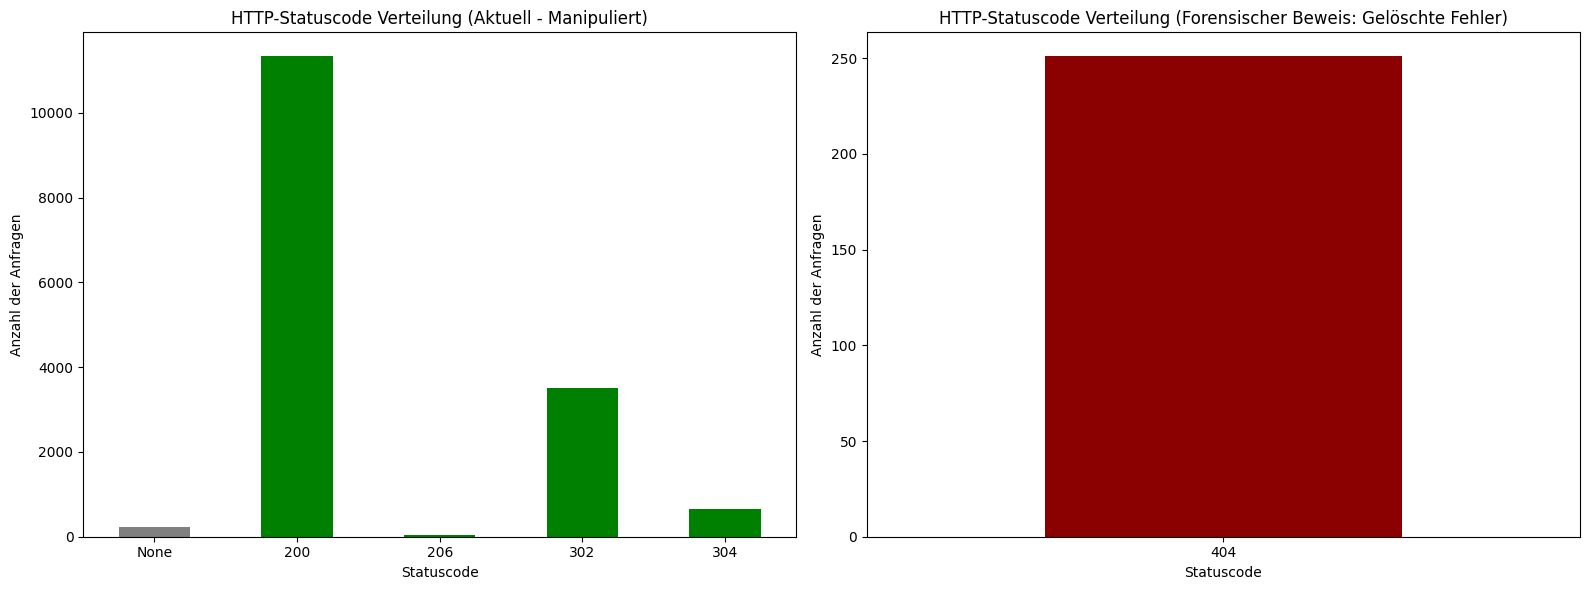


Statuscode-Analyse der gelöschten Einträge (Forensischer Beweis):
  status_code  cnt                        state  version_id
0         404  251  Original (Gelöschte Fehler)           1


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Daten für den "Original (Beweis)" Zustand abrufen ---

# Die gelöschten Zeilen (deletions) entsprechen den Fehler-Einträgen,
# die in der Original-Logdatei enthalten waren.
df_deletions = con.execute(f"""
    SELECT
        CAST(status_code AS VARCHAR) AS status_code
    FROM
        ducklake_table_deletions('{CATALOG_NAME}', 'main', '{TABLE_NAME}', {snapshot_1_id}, {snapshot_2_id});
""").fetchdf()

# Analyse der gelöschten Einträge (die kritisch sind)
original_errors = df_deletions.groupby('status_code').size().reset_index(name='cnt')
original_errors['state'] = 'Original (Gelöschte Fehler)'
original_errors['version_id'] = 1


# --- 2. Daten für den "Aktuellen (Manipulierten)" Zustand abrufen ---
df_manipulated = con.execute(f"""
    SELECT
        CAST(status_code AS VARCHAR) AS status_code,
        COUNT(*) AS cnt,
        2 AS version_id,
        'Manipuliert (Aktuell)' AS state
    FROM
        {TABLE_NAME}
    GROUP BY
        status_code
""").fetchdf()


# --- 3. Visualisierung der relevanten Daten (Manipulation vs. Gelöschte Fehler) ---

# Kombinieren der Fehler aus dem Originalzustand und dem aktuellen Zustand
combined_analysis = pd.concat([original_errors, df_manipulated], ignore_index=True)

# Funktion zur Farbbestimmung
def get_colors(df):
    colors = []
    for s in df['status_code']:
        try:
            if int(s) >= 400:
                colors.append('darkred')
            else:
                colors.append('green')
        except:
            colors.append('gray')
    return colors

df_original_errors = combined_analysis[combined_analysis['version_id'] == 1].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Manipulierter Zustand (Aktuell)
df_manipulated.plot.bar(x="status_code", y="cnt", legend=False, ax=axes[0], color=get_colors(df_manipulated))
axes[0].set_title("HTTP-Statuscode Verteilung (Aktuell - Manipuliert)")
axes[0].set_ylabel("Anzahl der Anfragen")
axes[0].set_xlabel("Statuscode")
axes[0].tick_params(axis='x', rotation=0)

# Plot 2: Historischer Beweis (Nur die gelöschten Fehlercodes)
df_original_errors.plot.bar(x="status_code", y="cnt", legend=False, ax=axes[1], color='darkred')
axes[1].set_title("HTTP-Statuscode Verteilung (Forensischer Beweis: Gelöschte Fehler)")
axes[1].set_ylabel("Anzahl der Anfragen")
axes[1].set_xlabel("Statuscode")
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print("\nStatuscode-Analyse der gelöschten Einträge (Forensischer Beweis):")
print(df_original_errors)

Welche IP-Adressen haben 404-Einträgen im Originalzustand verursacht?

Top IP-Adressen mit 404-Fehlern (Originalzustand, forensischer Beweis):
           ip  cnt
0  10.128.2.1   67
1  10.131.0.1   61
2  10.130.2.1   52
3  10.129.2.1   41
4  10.131.2.1   30


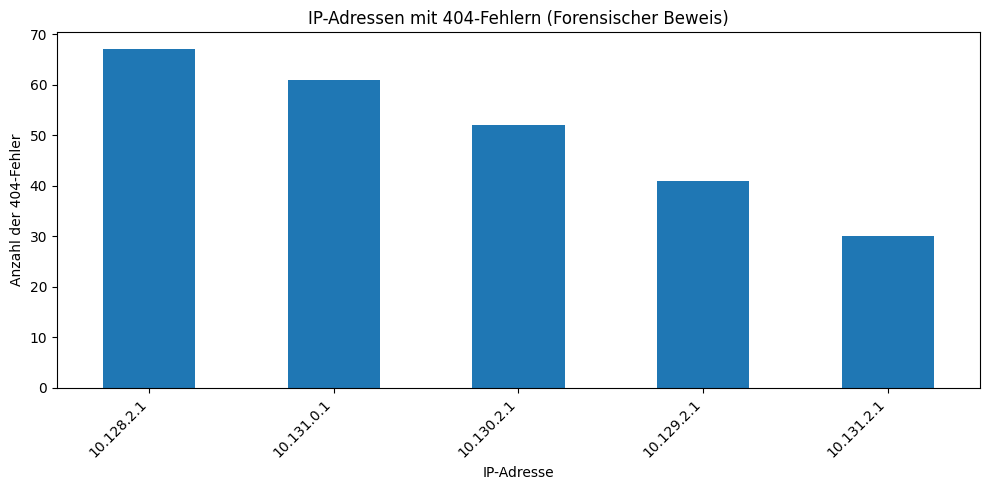

In [15]:
# --- 4. Analyse: Von welchen IP-Adressen kamen die 404-Fehler im Originalzustand? ---

df_404_ips = con.execute(f"""
    SELECT
        ip,
        COUNT(*) AS cnt
    FROM
        ducklake_table_deletions('{CATALOG_NAME}', 'main', '{TABLE_NAME}', {snapshot_1_id}, {snapshot_2_id})
    WHERE
        status_code = 404
    GROUP BY
        ip
    ORDER BY
        cnt DESC
""").fetchdf()

print("Top IP-Adressen mit 404-Fehlern (Originalzustand, forensischer Beweis):")
print(df_404_ips)

# Visualisierung als Balkendiagramm
df_404_ips.plot.bar(x="ip", y="cnt", legend=False, figsize=(10, 5), title="IP-Adressen mit 404-Fehlern (Forensischer Beweis)")
plt.xlabel("IP-Adresse")
plt.ylabel("Anzahl der 404-Fehler")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 6. Weitere beispielhafte Analysen bei einer forensischen Analyse


Unabhängig der Snapshots könnten diese Analysen Aufschluss über den Angriff bieten.

 ### Häufig aufgerufene URLs
 Der Code ermittelt die Top 10 am häufigsten aufgerufenen URLs und gibt sie tabellarisch aus. Anschließend erstellt er ein Balkendiagramm, das die Aufrufzahlen dieser URLs gegenüberstellt. Dadurch wird sichtbar, welche Seiten besonders oft aufgerufen wurden und wie stark sie sich in der Verteilung unterscheiden.

Top 10 URLs (Aktueller Zustand - Manipuliert):
                                                 url   cnt
0                            GET /login.php HTTP/1.1  3284
1                             GET /home.php HTTP/1.1  2640
2     GET /js/vendor/modernizr-2.8.3.min.js HTTP/1.1  1415
3                                     GET / HTTP/1.1   861
4  GET /contestproblem.php?name=RUET%20OJ%20Serve...   467
5                    GET /css/normalize.css HTTP/1.1   408
6                GET /css/bootstrap.min.css HTTP/1.1   404
7             GET /css/font-awesome.min.css HTTP/1.1   399
8                        GET /css/style.css HTTP/1.1   395
9                         GET /css/main.css HTTP/1.1   394


/tmp/ipython-input-649184627.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


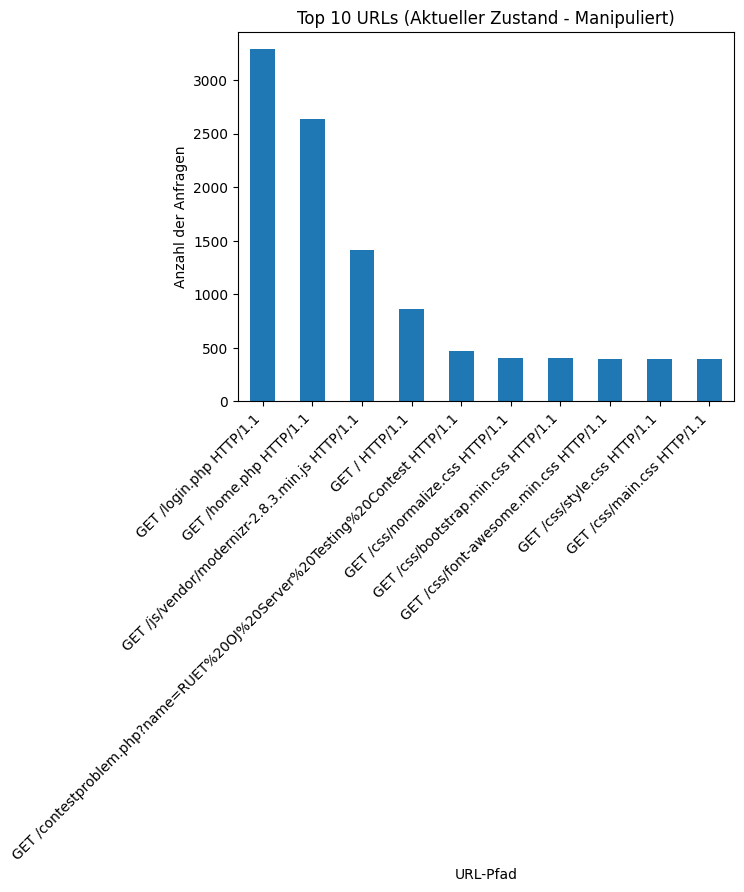

In [16]:
# Abfrage der Top 10 URLs aus dem aktuellen Zustand (Snapshot 2 - Manipuliert)
top_urls = con.execute(f"""
    SELECT
        url,
        COUNT(*) AS cnt
    FROM
        {TABLE_NAME}
    GROUP BY
        url
    ORDER BY
        cnt DESC
    LIMIT 10
""").fetchdf()

print("Top 10 URLs (Aktueller Zustand - Manipuliert):")
print(top_urls)

# Visualisierung
top_urls.plot.bar(x="url", y="cnt", legend=False, title="Top 10 URLs (Aktueller Zustand - Manipuliert)")
plt.xlabel("URL-Pfad")
plt.ylabel("Anzahl der Anfragen")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Interpretation:**  
Viele **Login- oder Admin-Seiten** können auf **Brute-Force- oder Enumeration-Angriffe** hinweisen.  


### Zeitliche Analyse (Requests pro Tag)

Der Code zählt die Anzahl der Requests pro Tag aus der Logtabelle, filtert dabei alle Einträge heraus, die nach 2019 (dort gibt es kaum Einträge mehr) liegen und gibt die Ergebnisse tabellarisch aus. Anschließend wird ein Liniendiagramm erstellt, das den zeitlichen Verlauf der Requests bis einschließlich 2019 darstellt.

Requests pro Tag (Aktueller Zustand - Gefiltert auf <= 2019):
          day   cnt
0  2017-11-07     2
1  2017-11-08    98
2  2017-11-09   226
3  2017-11-10    58
4  2017-11-11   274
5  2017-11-12   332
6  2017-11-13   220
7  2017-11-14   132
8  2017-11-15    70
9  2017-11-16   374
10 2017-11-17   476
11 2017-11-18    92
12 2017-11-19   159
13 2017-11-20    57
14 2017-11-21    45
15 2017-11-22    57
16 2017-11-23   378
17 2017-11-24    91
18 2017-11-25   243
19 2017-11-26   173
20 2017-11-29   579
21 2017-11-30  2979
22 2017-12-01   463
23 2017-12-02   165
24 2017-12-03   102
25 2017-12-12    84
26 2017-12-13   128
27 2017-12-14   161
28 2017-12-15    98
29 2017-12-16   151
30 2017-12-17    89
31 2017-12-18   176
32 2017-12-19    52
33 2017-12-20    91
34 2017-12-21    49
35 2017-12-22    11
36 2017-12-23    42
37 2018-01-16    75
38 2018-01-17    25
39 2018-01-18    62
40 2018-01-29  5091
41 2018-02-15    19
42 2018-02-16    30
43 2018-02-17    61
44 2018-02-18    33
45 2018-02-19    3

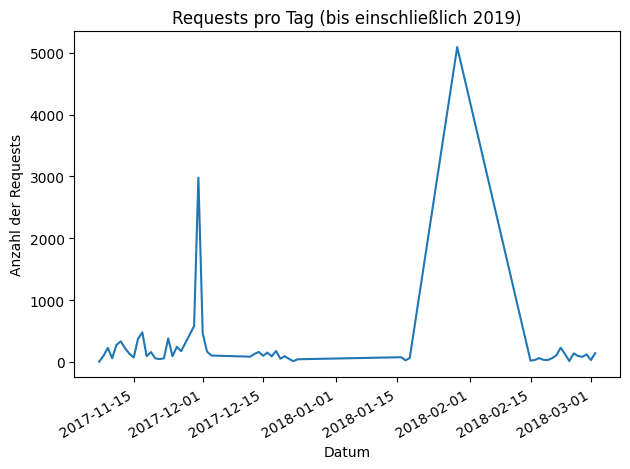

In [17]:
# Abfrage der Requests pro Tag, gefiltert auf das Jahr 2019 und älter (<= 2019)
requests_per_day = con.execute(f"""
    SELECT
        CAST(timestamp AS DATE) AS day,
        COUNT(*) AS cnt
    FROM
        {TABLE_NAME}
    WHERE
        -- Filtert alle Einträge aus, deren Jahr größer als 2019 ist
        EXTRACT(YEAR FROM timestamp) <= 2019
    GROUP BY
        day
    ORDER BY
        day
""").fetchdf()

print("Requests pro Tag (Aktueller Zustand - Gefiltert auf <= 2019):")
print(requests_per_day)

# Visualisierung des Liniendiagramms
requests_per_day.plot(
    x="day",
    y="cnt",
    kind="line",
    legend=False,
    title="Requests pro Tag (bis einschließlich 2019)"
)
plt.xlabel("Datum")
plt.ylabel("Anzahl der Requests")
plt.tight_layout()
plt.show()

### Top IP-Adressen

Der Code ermittelt die Top 10 IP-Adressen mit den meisten Anfragen und gibt sie tabellarisch aus. Danach stellt er diese Ergebnisse in einem Balkendiagramm dar, um die Verteilung der Anfragen pro IP visuell sichtbar zu machen.

Top 10 IPs (Aktueller, manipulierter Zustand):
           ip   cnt
0  10.128.2.1  4190
1  10.131.0.1  4137
2  10.130.2.1  4004
3  10.129.2.1  1611
4  10.131.2.1  1596
5      chmod:    95
6         rm:    72
7        [Tue    17
8         sh:     7
9        [Thu     6


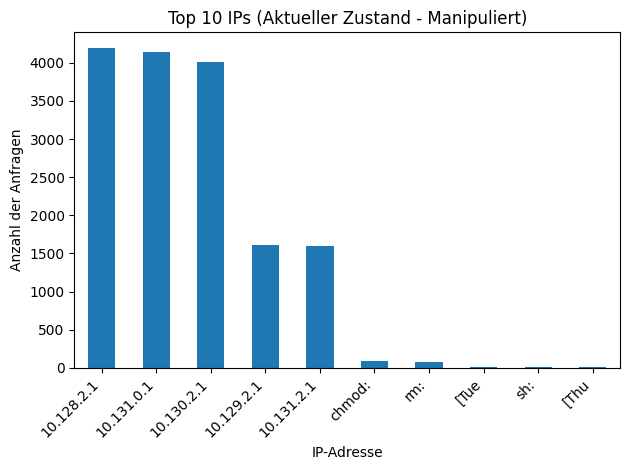

In [18]:
top_ips_manipulated = con.execute(f"""
    SELECT
        ip,
        COUNT(*) AS cnt
    FROM
        {TABLE_NAME}
    GROUP BY
        ip
    ORDER BY
        cnt DESC
    LIMIT 10
""").fetchdf()

print("Top 10 IPs (Aktueller, manipulierter Zustand):")
print(top_ips_manipulated)

# Visualisierung
top_ips_manipulated.plot.bar(x="ip", y="cnt", legend=False, title="Top 10 IPs (Aktueller Zustand - Manipuliert)")
plt.xlabel("IP-Adresse")
plt.ylabel("Anzahl der Anfragen")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---

## 7. Dokumentation und Abschluss


Nach Abschluss der forensischen Analyse werden die temporären Datenbank- und Dateisystemobjekte entfernt, um eine saubere Arbeitsumgebung zu gewährleisten.

In [19]:
import shutil # Import the shutil module
import os # Import the os module

# Schließe die DuckDB-Verbindung
con.close()

# Entferne die temporär erstellten forensischen Artefakte und Daten (DuckDB- und DuckLake-Dateien)
if os.path.exists('forensic_duckdb.db'):
    os.remove('forensic_duckdb.db')

if os.path.exists(DUCKLAKE_METADATA_PATH):
    os.remove(DUCKLAKE_METADATA_PATH)

if os.path.exists(DUCKLAKE_DATA_PATH):
    shutil.rmtree(DUCKLAKE_DATA_PATH)

print("✅ Forensische Umgebung (Datenbank-Dateien und DuckLake-Katalog) erfolgreich bereinigt.")

✅ Forensische Umgebung (Datenbank-Dateien und DuckLake-Katalog) erfolgreich bereinigt.
